In [1]:
from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import warnings # 0 warnings :)
warnings.filterwarnings("ignore")
from matplotlib.pyplot import figure
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import graphviz
import json
import iplotter
from IPython.core.display import HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from IPython.display import SVG
import pydotplus
#http://markibrahim.me/musings/notebooks/beautiful_javascript_charts.html

In [2]:
df = pd.read_csv('electricity.csv')
df.drop_duplicates()
df = df.dropna()
df['Utility.State'] = df['Utility.State'].astype('category')
df['Utility.Type'] = df['Utility.Type'].astype('category')
df = df.rename(columns={'Demand.Summer Peak': 'Demand.SummerPeak', 'Demand.Winter Peak': 'Demand.WinterPeak', 'Uses.No Charge':'Uses.NoCharge'})


### Winter Peak Tree

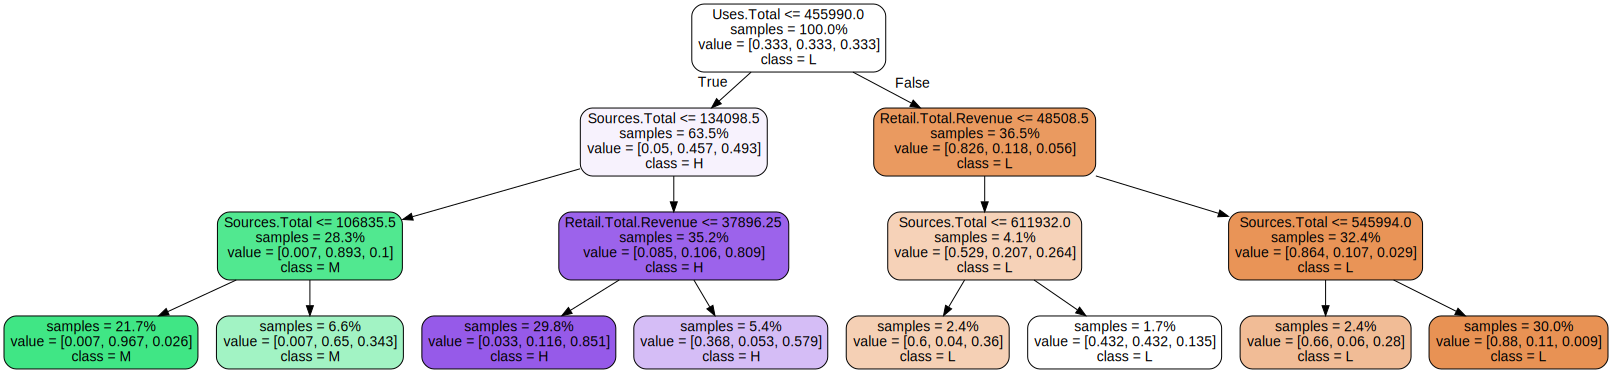

In [3]:
df_WinterPeak = pd.DataFrame()
df_WinterPeak['Ranking'] = pd.qcut(df['Demand.WinterPeak'], q =3, labels = ["L","M","H"])
attributes = df[['Sources.Total','Uses.Total','Revenue.Total','Retail.Total.Revenue']]
target = df_WinterPeak['Ranking']
Tree = tree.DecisionTreeClassifier(max_depth = 3)
Tree.fit(attributes, target)
dot_data = tree.export_graphviz(Tree,
                               out_file=None,
                               feature_names=attributes.columns,
                               class_names = ["L","M","H"],
                               proportion=True,
                               impurity=False,
                               filled=True,
                               rounded=True)
graph = graphviz.Source(dot_data)
#graph.render('WinterPeakTree')
graph

### Summer Peak Tree

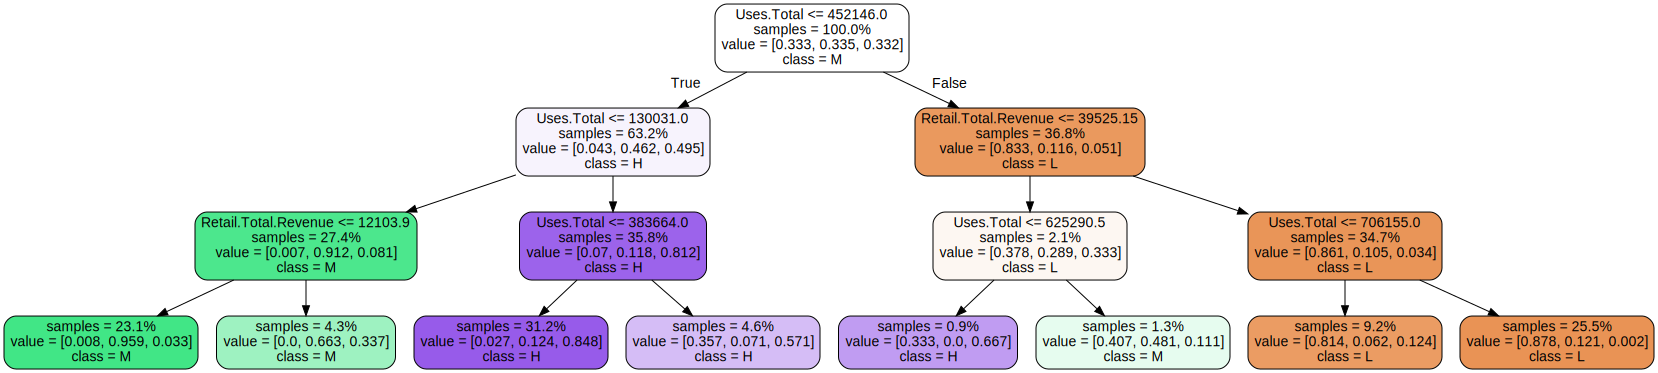

In [4]:
df_SummerPeak = pd.DataFrame()
df_SummerPeak['Ranking'] = pd.qcut(df['Demand.SummerPeak'], q =3, labels = ["L","M","H"])
attributes = df[['Sources.Total','Uses.Total','Revenue.Total','Retail.Total.Revenue']]
target = df_SummerPeak['Ranking']
Tree = tree.DecisionTreeClassifier(max_depth = 3)
Tree.fit(attributes, target)
dot_data = tree.export_graphviz(Tree,
                               out_file=None,
                               feature_names=attributes.columns,
                               class_names = ["L","M","H"],
                               proportion=True,
                               impurity=False,
                               filled=True,
                               rounded=True)
graph = graphviz.Source(dot_data)
#graph.render('SummerPeakTree')
graph

### Find best winter peak tree

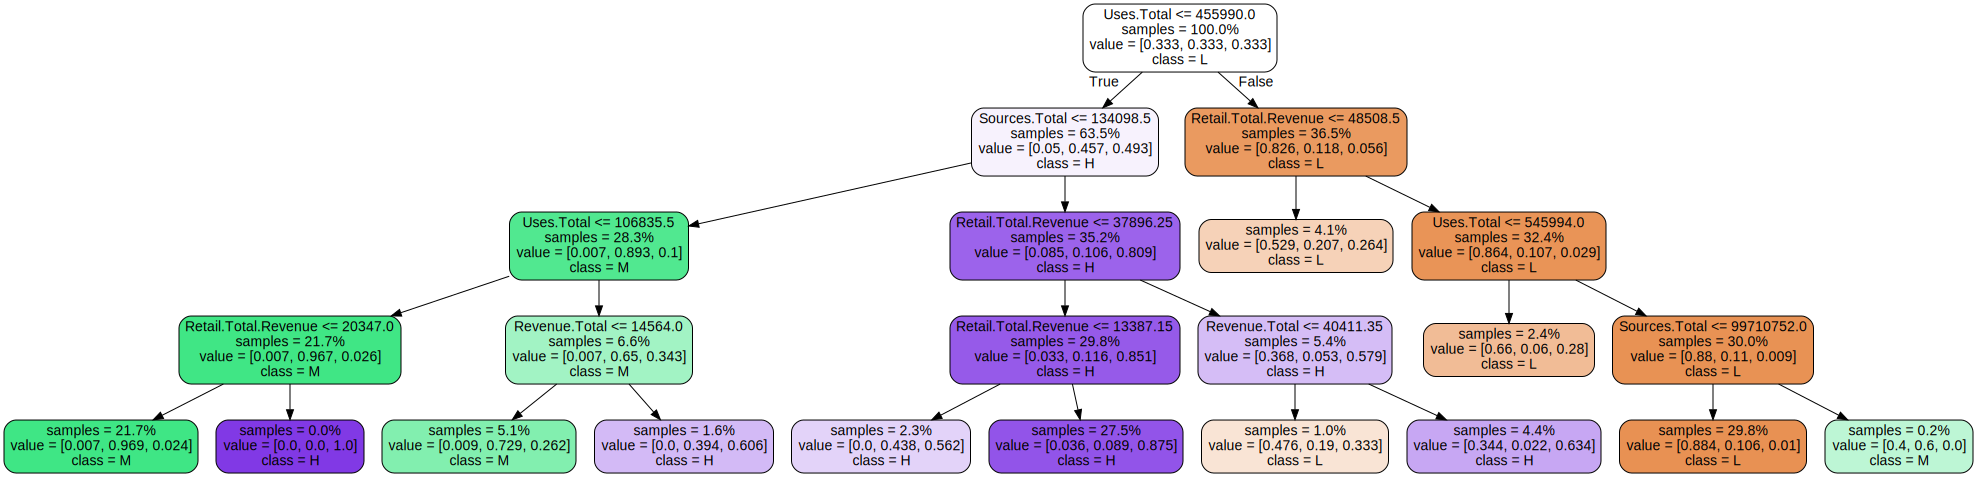

In [5]:
parameters = {'max_depth': [2,3,4,5,6], 'min_samples_split':[50,60,70,80,85,86,87,88,89,90,91,92,93,95,100,110,120]}
Tree = tree.DecisionTreeClassifier()
TreeCV = GridSearchCV(Tree, param_grid = parameters, n_jobs = -1)
### calculation
attributes = df[['Sources.Total','Uses.Total','Revenue.Total','Retail.Total.Revenue']]
target = df_WinterPeak['Ranking']
TreeCV.fit(attributes, target)
TreeCV.best_params_
dot_data = tree.export_graphviz(TreeCV.best_estimator_,
            out_file=None,
            feature_names=attributes.columns,
            class_names = df_WinterPeak['Ranking'].cat.categories,
            proportion=True,
            impurity=False,
            filled=True,
            rounded=True)
winter_best = graphviz.Source(dot_data)
# graph.render('WinterPeakUsage-best')
winter_best

### Find the best Summer Peak Tree

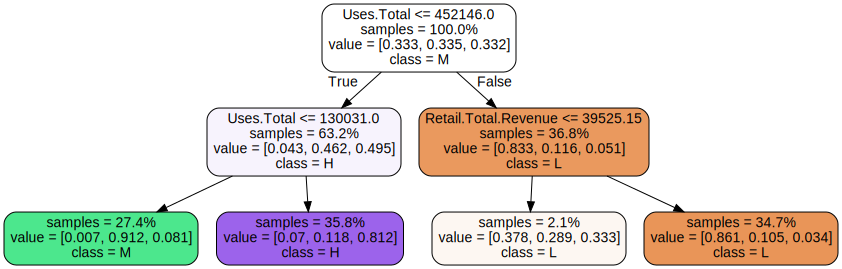

In [6]:
parameters = {'max_depth': [1,2,3,4,5,6], 'min_samples_split':[1,2,3,4,5,6,7,10,20,30,40,50,60,70,80,85,86]}
Tree = tree.DecisionTreeClassifier()
TreeCV = GridSearchCV(Tree, param_grid = parameters, n_jobs = -1)
### calculation
attributes = df[['Sources.Total','Uses.Total','Revenue.Total','Retail.Total.Revenue']]
target = df_SummerPeak['Ranking']
TreeCV.fit(attributes, target)
TreeCV.best_params_
dot_data = tree.export_graphviz(TreeCV.best_estimator_,
            out_file=None,
            feature_names=attributes.columns,
            class_names = df_SummerPeak['Ranking'].cat.categories,
            proportion=True,
            impurity=False,
            filled=True,
            rounded=True)
summer_best = graphviz.Source(dot_data)
#graph.render('SummerPeakUsage-best')
summer_best

### Naive Bayes on Summer Peak

<AxesSubplot:xlabel='hparam'>

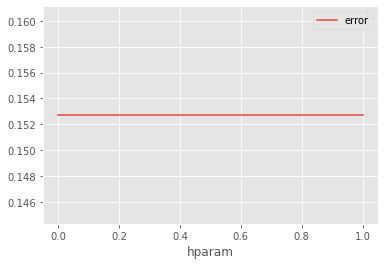

In [7]:
df_resample = df.sample(frac=1.0, random_state=0).reset_index(drop=True)
attributes = df_resample[['Sources.Total','Uses.Total','Revenue.Total','Retail.Total.Revenue']]
target = df_resample['Demand.SummerPeak']
target = pd.qcut(target,q=2,labels=['L','H'])
for j in range(attributes.shape[1]):
    attributes.iloc[:,j] = pd.qcut(attributes.iloc[:,j],q=3,labels=['S','M','L'])
# attributes.head(3)
attributes = pd.get_dummies(attributes)
hparam = {'alpha':[10**(-10),0.1,0.2,0.3,0.4,1]}
NBayes = MultinomialNB()
NBayesCV = GridSearchCV(NBayes, param_grid = hparam)
NBayesCV.fit(attributes, target)
results = pd.DataFrame()
results['hparam'] = hparam['alpha']
results['error']  = 1 - NBayesCV.cv_results_['mean_test_score']
results.plot.line(x='hparam',y='error')

In [8]:
NBayesCV.best_params_
error_bayes = 1 - NBayesCV.best_score_
print('Navie Bayes validation error rate: ', error_bayes.round(3))

Navie Bayes validation error rate:  0.153


### Logistic Regression on Summer Peak 

<AxesSubplot:xlabel='hparam'>

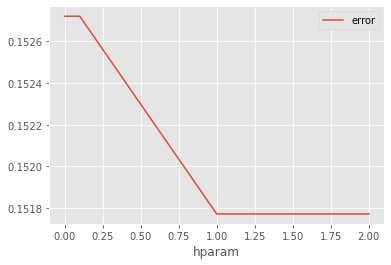

In [9]:
lgr = LogisticRegression()
hparam = {'C' : [0.0001,0.001,0.01,0.1,1,2]}
lgrCV = GridSearchCV(lgr, param_grid = hparam)
lgrCV.fit(attributes, target)
results = pd.DataFrame()
results['hparam'] = hparam['C']
results['error']  = 1 - lgrCV.cv_results_['mean_test_score']
results.plot.line(x='hparam',y='error')

In [10]:
error_logistic = 1 - lgrCV.best_score_
print('Logistic regression validation error rate: ', error_logistic.round(3))

Logistic regression validation error rate:  0.152


### Decision Tree on Summer Peak 

<AxesSubplot:xlabel='hparam'>

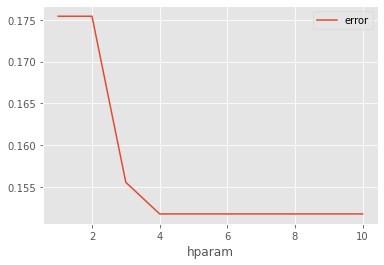

In [11]:
hparam = {'max_depth' : [1,2,3,4,5,6,7,8,9,10]}
Tree = DecisionTreeClassifier()
TreeCV = GridSearchCV(Tree, param_grid = hparam)
TreeCV.fit(attributes, target)
results = pd.DataFrame()
results['hparam'] = hparam['max_depth']
results['error']  = 1 - TreeCV.cv_results_['mean_test_score']
results.plot.line(x='hparam',y='error')

In [12]:
error_tree = 1- TreeCV.best_score_
print('Tree validation error rate: ', error_tree.round(3))

Tree validation error rate:  0.152


### Trying some interactive stuff

In [13]:
input_slider = widgets.IntSlider(value=3,min=0,max=10,description='Max_depth:')
def identity(x):
    return x
interact(identity, x=input_slider)

interactive(children=(IntSlider(value=3, description='Max_depth:', max=10), Output()), _dom_classes=('widget-i…

<function __main__.identity(x)>

In [14]:
## trying with a winter decision tree
df_WinterPeak = pd.DataFrame()
df_WinterPeak['Ranking'] = pd.qcut(df['Demand.WinterPeak'], q =2, labels = ["L","H"])
attributes = df[['Sources.Total','Uses.Total','Revenue.Total','Retail.Total.Revenue']]
target = df_WinterPeak['Ranking']

def win_tree(x):
    Tree = tree.DecisionTreeClassifier(max_depth = x)
    Tree.fit(attributes, target)
    dot_data = tree.export_graphviz(Tree,
                                   out_file=None,
                                   feature_names=attributes.columns,
                                   class_names = ["L","H"],
                                   proportion=True,
                                   impurity=False,
                                   filled=True,
                                   rounded=True)
    #src = graphviz.Source(dot_data)
    #return display(SVG(src.pipe(format='svg')))
    # return graph
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    pydot_graph.set_size('"5,20!"')
    # return pydot_graph
    gvz_graph = graphviz.Source(pydot_graph.to_string())
    return gvz_graph
    
input_slider = widgets.IntSlider(value=3,min=1,max=6,description='Max_depth:')
interact(win_tree, x=input_slider)

interactive(children=(IntSlider(value=3, description='Max_depth:', max=6, min=1), Output()), _dom_classes=('wi…

<function __main__.win_tree(x)>

### C3.js

### Scatter Plot

In [15]:
df_Su_Wi = df[['Demand.SummerPeak', 'Demand.WinterPeak']]
### drop rows with all zero values
df_Su_Wi = df_Su_Wi.loc[~(df_Su_Wi==0).all(axis=1)]
### drop the rows with values that are too low
df_Su_Wi_bound = 200
df_Su_Wi = df_Su_Wi[(df_Su_Wi['Demand.SummerPeak'] >= df_Su_Wi_bound) & (df_Su_Wi['Demand.WinterPeak'] >= df_Su_Wi_bound)]
df_Su_Wi = df_Su_Wi.T.reset_index()
df_Su_Wi

,index,11,13,23,45,49,55,57,58,59,...,1977,1997,2005,2006,2036,2046,2054,2059,2080,2091
0,Demand.SummerPeak,211.5,10967.0,538.0,562.0,504.7,5596.0,7367.0,4616.0,303.2,...,8000.0,7161.0,312.1,580.3,373.9,1496.5,9239.0,462.0,773.5,774.8
1,Demand.WinterPeak,232.0,10660.0,531.0,344.0,347.2,6967.0,4303.0,3735.0,320.1,...,7500.0,6170.0,281.3,422.6,257.1,1437.0,7543.0,391.0,571.6,515.4


In [16]:
data_Su_wi_scatt = {
    "data": {
        "columns": [
            df_Su_Wi.iloc[0,:].values.flatten().tolist(),
            df_Su_Wi.iloc[1,:].values.flatten().tolist()
        ],
     "type": 'scatter'
            },
    "axis": {
        "x": {
            "label": 'Utilities',
            "tick": {
                "fit": "false"
            }
        },
        "y": {
            "label": 'PeakUsage'
        }
    }
}

In [17]:
c3_plotter = iplotter.C3Plotter()
c3_plotter.plot(data_Su_wi_scatt)

### Line plot - compare power generated and use loss¶

In [18]:
pwr_generated_tot = df[['Sources.Total','Utility.State']].groupby('Utility.State').sum()
pwr_generated_tot.reset_index(inplace=True)
pwr_generated_tot = pwr_generated_tot.rename(columns={'Sources.Total': 'Total Generation of Power (MWh)', 'Utility.State':'Utility by State'})
pwr_generated_tot.head(3)

,Utility by State,Total Generation of Power (MWh)
0,AK,6916431.0
1,AL,94490013.0
2,AR,55715570.0


In [19]:
use_loss_tot = df[['Uses.Losses','Utility.State']].groupby('Utility.State').sum()
use_loss_tot.reset_index(inplace=True)
use_loss_tot = use_loss_tot.rename(columns={'Uses.Losses': 'Power losses of all kinds measured in megawatt hours', 'Utility.State':'Utility by State'})
use_loss_tot.head(3)

,Utility by State,Power losses of all kinds measured in megawatt hours
0,AK,357085.0
1,AL,4448349.0
2,AR,3068421.0


In [20]:
df_gen_los = pd.merge(pwr_generated_tot, use_loss_tot)
df_gen_los = df_gen_los.drop("Utility by State", axis = 1)
## drop rows with two 0 entries
df_gen_los = df_gen_los.loc[~(df_gen_los==0).all(axis=1)]
df_gen_los = df_gen_los.T.reset_index()
df_gen_los['index']

0                      Total Generation of Power (MWh)
1    Power losses of all kinds measured in megawatt...
Name: index, dtype: object

In [21]:
data_Su_wi_scatt_lin = {
    "data": {
        "columns": [
            df_gen_los.iloc[0,:].values.flatten().tolist(),
            df_gen_los.iloc[1,:].values.flatten().tolist()
        ],
        "types": {
            df_gen_los['index'][0]: 'area-spline',
            df_gen_los['index'][1]: 'area-spline'
        },
        "groups": [[df_gen_los['index'][0], df_gen_los['index'][1]]]
    }
}
c3_plotter.plot(data_Su_wi_scatt_lin)

In [22]:
df.dtypes

Utility.Number                        int64
Utility.Name                         object
Utility.State                      category
Utility.Type                       category
Demand.SummerPeak                   float64
Demand.WinterPeak                   float64
Sources.Generation                  float64
Sources.Purchased                   float64
Sources.Other                       float64
Sources.Total                       float64
Uses.Retail                         float64
Uses.Resale                         float64
Uses.NoCharge                       float64
Uses.Consumed                       float64
Uses.Losses                         float64
Uses.Total                          float64
Revenues.Retail                     float64
Revenue.Delivery                    float64
Revenue.Resale                      float64
Revenue.Adjustments                 float64
Revenue.Transmission                float64
Revenue.Other                       float64
Revenue.Total                   

In [23]:
source_avg_data = [
        ['Source_Average','value'], 
        ['Sources.Generation', round(df['Sources.Generation'].mean(), 2)], 
        ['Sources.Purchased', round(df['Sources.Purchased'].mean(), 2)],
        ['Sources.Other', round(df['Sources.Other'].mean(), 2)]
                  ]
print("%s" % source_avg_data)

[['Source_Average', 'value'], ['Sources.Generation', 1059884.64], ['Sources.Purchased', 1492859.43], ['Sources.Other', 23689.91]]


In [24]:
# remove iFrame border for cleaner chart rendering
# increase size of text explanations
HTML("""
<style>
iframe {border:0;}
</style>
""")

In [25]:
html_code = """
<html>
  <head>
    <script type="text/javascript" src="https://www.gstatic.com/charts/loader.js"></script>
    <script type="text/javascript">
      google.charts.load("current", {packages:["corechart"]});
      google.charts.setOnLoadCallback(drawChart);
      function drawChart() {
        var data = google.visualization.arrayToDataTable([['Source_Average', 'value'], ['Sources.Generation', 1059884.64], ['Sources.Purchased', 1492859.43], ['Sources.Other', 23689.91]]);

        var options = {
          title: "Power Source Break Down (Mean)",
          pieHole: 0.4,
        };

        var chart = new google.visualization.PieChart(document.getElementById('donutchart'));
        chart.draw(data, options);
      }
    </script>
  </head>
  <body>
    <div id="donutchart" style="width: 900px; height: 520px;"></div>
  </body>
</html>
"""


In [26]:
HTML(html_code)